# Google colab commands

In [ ]:
!git clone https://github.com/Francesco9932/financial-sentiment-analysis

In [ ]:
%cd financial-sentiment-analysis/

In [ ]:
!unzip glove.6B.200d.txt.zip

# Data preprocessing and test-train split

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('all-data.csv', encoding="latin-1",
                 names=['sentiment', 'headline'])
df.head()

,sentiment,headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


<AxesSubplot:>

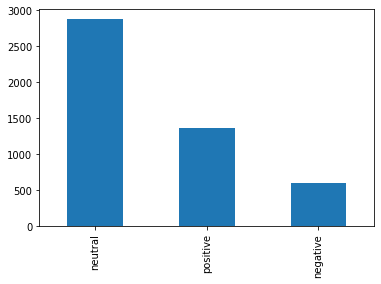

In [3]:
df['sentiment'].value_counts().plot(kind='bar')

In [4]:
print("original shape: ", df.shape)
df = df.drop_duplicates()
print("after drop duplicates shape: ", df.shape)
dd_dn = df.dropna()
print("after drop null shape: ", df.shape)

original shape:  (4846, 2)
after drop duplicates shape:  (4840, 2)
after drop null shape:  (4840, 2)


In [5]:
df['headline'][1]

'Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .'

In [6]:
from sklearn.preprocessing import LabelEncoder

sentences = df['headline'].to_list()

# Encode target labels
le = LabelEncoder()
le.fit(df['sentiment'])
df['sentiment'] = le.transform(df['sentiment'])

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification

finbert = TFBertForSequenceClassification.from_pretrained(
    'ProsusAI/finbert', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')

# BERT Finetune (finBERT)

In [7]:
from transformers import BertTokenizer
from transformers import TFBertModel

tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
bert = TFBertModel.from_pretrained('ProsusAI/finbert')

2023-04-20 19:52:33.981457: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-20 19:52:33.981497: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-20 19:52:33.981522: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (francesco-Modern-15-A11M): /proc/driver/nvidia/version does not exist
2023-04-20 19:52:33.981867: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
All model checkpoint layers were used when initializing TFBertModel.

All the layers of TF

In [8]:
# calculate the max sentence lenght:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)


Max sentence length:  150


In [9]:
train_sentences, test_sentences, labels_train, labels_test = train_test_split(
    sentences, df['sentiment'], train_size=0.7, shuffle=True, random_state=1)

X_train = tokenizer(
    text=train_sentences,
    add_special_tokens=True,
    max_length=120,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_test = tokenizer(
    text=test_sentences,
    add_special_tokens=True,
    max_length=120,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

In [11]:
X_test['input_ids'].shape

TensorShape([1452, 120])

In [12]:
input_ids = tf.keras.layers.Input(shape=(120,), dtype=tf.int32, name="input_ids")
input_mask = tf.keras.layers.Input(shape=(120,), dtype=tf.int32, name="attention_mask")

embeddings = bert(input_ids, attention_mask=input_mask)[0]  # 0 = last hidden state, 1 = poller_output

out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = tf.keras.layers.Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = tf.keras.layers.Dense(32, activation='relu')(out)

y = tf.keras.layers.Dense(3, activation='softmax')(out)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = False

optimizer = tf.keras.optimizers.Adam(
    learning_rate=5e-05,  # HF recommendation
    epsilon=1e-08,
    #decay=0.01,
    clipnorm=1.0
)

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.CategoricalAccuracy('balanced_accuracy')

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 120)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 120)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 120,                                           

In [15]:
history = model.fit(
    x={'input_ids': X_train['input_ids'],
        'attention_mask': X_train['attention_mask']},
    y=tf.keras.utils.to_categorical(labels_train),
    epochs=2,
    batch_size=32
)

Epoch 1/2
106/106 [==============================] - 370s 3s/step - loss: 0.5574 - balanced_accuracy: 0.7822
Epoch 2/2
106/106 [==============================] - 387s 4s/step - loss: 0.4440 - balanced_accuracy: 0.8253


In [ ]:
X_test['input_ids'].shape
#X_train['input_ids'].shape

In [16]:
# da sistemare
from sklearn.metrics import classification_report

predicted = model.predict(
    {'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
y_predicted = np.argmax(predicted, axis=1)
print(classification_report(labels_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       171
           1       0.88      0.94      0.91       862
           2       0.87      0.76      0.81       419

    accuracy                           0.88      1452
   macro avg       0.89      0.85      0.87      1452
weighted avg       0.88      0.88      0.88      1452



# Preprocessing NLTK for other models

In [ ]:
from nltk.stem.porter import *
from nltk.corpus import stopwords
import re
import nltk  # natural language processing
nltk.download("stopwords")

In [ ]:
def headline_to_words(headline):
    ''' Convert headline text into a sequence of words '''
    
    # convert to lowercase
    text = headline.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal headline ->", df['news headline'][0])
print("\nProcessed headline ->", headline_to_words(df['news headline'][0]))

In [ ]:
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
print("Vocab length:", len(word_index) + 1)

max_seq_length = np.max(list(map(lambda x: len(x), sequences)))
print("Maximum sequence length:", max_seq_length)
sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

In [ ]:
train_sequences, test_sequences, y_train, y_test = train_test_split(sequences, Y, train_size=0.7, shuffle=True, random_state=1)

In [ ]:
print('Train Set ->', train_sequences.shape, y_train.shape)
print('Test Set ->', test_sequences.shape, y_test.shape)

# Global Vectors for Word Representation (GloVe)

In [ ]:
vocab_size = 7714
embedding_size = 200

embeddings_index = {}

with open('glove.6B.200d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


embeddings_matrix = np.zeros((vocab_size+1, embedding_size))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [ ]:
print(embeddings_matrix.shape)

# CNN1d Model

In [ ]:
inputs = tf.keras.Input(shape=(train_sequences.shape[1],))
x = tf.keras.layers.Embedding(input_dim=vocab_size+1,
                              output_dim=embedding_size,
                              input_length=train_sequences.shape[1],
                              weights=[embeddings_matrix])(inputs)

convs = []
filter_sizes = [2,3,4,5,6]

for filter_size in filter_sizes:
    l_conv = tf.keras.layers.Conv1D(filters=200, 
                        kernel_size=filter_size, 
                        activation='relu')(x)
    l_pool = tf.keras.layers.GlobalMaxPooling1D()(l_conv)
    convs.append(l_pool)

l_merge = tf.keras.layers.concatenate(convs, axis=1)
x = tf.keras.layers.Dropout(0.1)(l_merge)  
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:
epochs = 100
batch_size=32

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./best_model/best_model_cnn1d.h5', 
                     monitor='val_accuracy', mode='max', verbose=1, 
                     save_best_only=True)

history = model.fit(train_sequences,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_split=0.1,
                    callbacks=[es, mc])

In [ ]:
saved_model = load_model('./best_model/best_model_cnn1d.h5')

results = saved_model.evaluate(test_sequences, y_test, verbose =  0)

print("Test Losss: {:.5f}".format(results[0]))
print("Test accuracy: {:.5f}%".format(results[1]  * 100))

# LSTM Model

In [ ]:
inputs = tf.keras.Input(shape=(train_sequences.shape[1],))
x = tf.keras.layers.Embedding(input_dim=vocab_size,
                              output_dim=embedding_size,
                              input_length=train_sequences.shape[1])(inputs)
x = tf.keras.layers.LSTM(256, return_sequences=True, activation='tanh')(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
epochs = 100
batch_size=32

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./best_model/best_model_lstm.h5', 
                     monitor='val_accuracy', mode='max', verbose=1, 
                     save_best_only=True)

history = model.fit(train_sequences,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_split=0.1,
                    callbacks=[es, mc])

In [ ]:
saved_model = load_model('./best_model/best_model_lstm.h5')

results = saved_model.evaluate(test_sequences, y_test, verbose =  0)

print("Test Losss: {:.5f}".format(results[0]))
print("Test accuracy: {:.5f}%".format(results[1]  * 100))